In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import shutil
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion() # interactive mode

import warnings
# filter warnings

In [ ]:

def train_val_split(data_dir, val_ratio=0.2):
    """
    Splits images from the 'train' folder into training and validation sets
    by moving files to separate folders.
    
    Arguments:
    data_dir (str): Path to the directory with images.
    val_ratio (float): The proportion of data to be used for validation set.
    """
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')

    # Create the validation folder if it does not exist
    os.makedirs(val_dir, exist_ok=True)

    # Iterate through all subdirectories (classes) in the 'train' folder
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        # Check if it is a directory (for example, 'ants', 'bees')
        if os.path.isdir(class_train_path):
            # Create the corresponding class folder in the 'val' directory if it does not exist
            os.makedirs(class_val_path, exist_ok=True)

            # Get a list of all images in the current class folder
            images = os.listdir(class_train_path)
            

            num_val_images = int(len(images) * val_ratio)
            val_images = random.sample(images, num_val_images)

            # Move the selected validation images to the 'val' folder
            for image in val_images:
                src = os.path.join(class_train_path, image)
                dst = os.path.join(class_val_path, image)
                shutil.move(src, dst)

    print(f'Moving completed. {val_ratio*100}% of the data moved to the validation set.')

In [2]:

data_dir = './data'

# Download data

Дані вже розподілено на окремі папки train та test. Із тренувального набору додатково виділено 20% даних як валідацііний набір для відстеження метрик в процесі навчання. За допомогою функції train_val_split створено окрему папку val із випадково обраними зразками з тренувального набору.


In [ ]:
train_val_split(data_dir, val_ratio=0.2)

# Transform data and create datasets

Створено трансформер для тренувальних та валідаційних зображень. Всі нормалізовано та приведено до розміру 224*224 як вимога для застосування трансферного навчання за допомогою ResNet. До тренувальних зображень застосовані додатково методт аугментації задля зниження перенавчання.

In [3]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 11230, 'val': 2804}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Check batch sample 

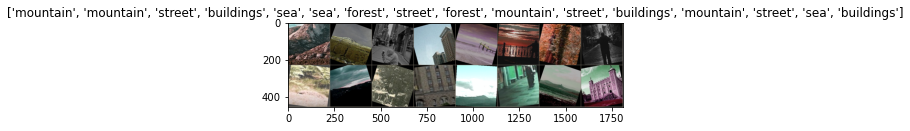

In [5]:

def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # Imagenet mean
    std = np.array([0.229, 0.224, 0.225]) # Imagenet std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# %%

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train model

Спочатку застосовано транферне навчання за допомогою ResNet50. Оцінено якість навчання із тренуванням всіх ваг та із заморозкою ваг, окрім класифікаційного шару. Оптимізатор обрано Adam як більш ефективний, а функція втрат - функція крос-ентропії, оскільки маємо задачу багатокласової класифікації.

In [6]:

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        

In [14]:

model_ft = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

In [15]:

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.1725 Acc: 0.6152
val Loss: 0.4355 Acc: 0.8734

Epoch 2/10
----------
train Loss: 0.5988 Acc: 0.7860
val Loss: 0.3061 Acc: 0.9009

Epoch 3/10
----------
train Loss: 0.5125 Acc: 0.8118
val Loss: 0.2559 Acc: 0.9144

Epoch 4/10
----------
train Loss: 0.4669 Acc: 0.8310
val Loss: 0.2619 Acc: 0.9176

Epoch 5/10
----------
train Loss: 0.4213 Acc: 0.8502
val Loss: 0.2436 Acc: 0.9201

Epoch 6/10
----------
train Loss: 0.4109 Acc: 0.8528
val Loss: 0.2229 Acc: 0.9262

Epoch 7/10
----------
train Loss: 0.3993 Acc: 0.8579
val Loss: 0.2226 Acc: 0.9219

Epoch 8/10
----------
train Loss: 0.3765 Acc: 0.8625
val Loss: 0.2089 Acc: 0.9294

Epoch 9/10
----------
train Loss: 0.3664 Acc: 0.8691
val Loss: 0.2085 Acc: 0.9258

Epoch 10/10
----------
train Loss: 0.3540 Acc: 0.8735
val Loss: 0.2021 Acc: 0.9262

Training complete in 25m 32s
Best val Acc: 0.929387


C:\Users\krist\AppData\Local\Temp\ipykernel_35556\2894891286.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


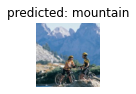

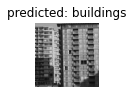

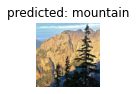

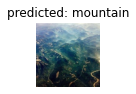

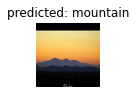

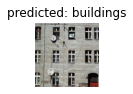

In [19]:

visualize_model(model_ft)

# Model evaluation

Перевіримо точність моделі на тестових даних, які вона не бачила під час навчання. Розраховано accuracy, f1-score, візуалізовано матрицю помилок.

In [12]:

test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                          data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=0)

def evaluate_model(model, test_dataset, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
        
            _, preds = torch.max(outputs, 1)
        
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'F1 Score: {f1:.4f}')

    #  confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.9273
F1 Score: 0.9269


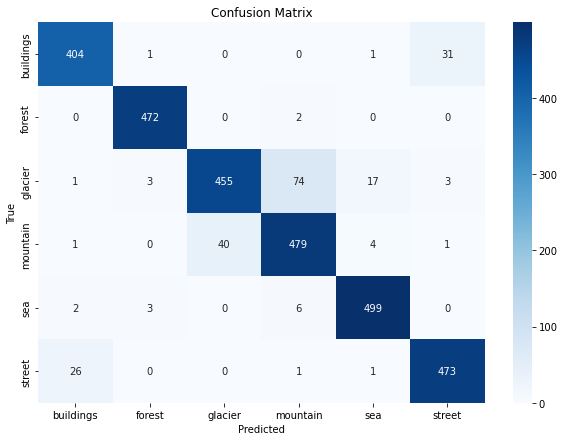

In [16]:
evaluate_model(model_ft, test_dataset, test_loader)

Отже, accuracy на тестовому наборі відповідає accuracy на валідаційному наборі. На візуалізації матриці помилок бачимо, що модель плутає категорії гір та льодовиків, що очікувано, бо ці зображення схожі за наявними патернами та текстурами, а також дома та вулиці, що також очікувано і логічно. Краще за все модель класифікує зображення лісу.

Далі натренуємо модель ResNet50 із замороженими вагами, окрім класифікаційного шару.

In [17]:

model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V2')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-04) 

In [18]:

model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.2900 Acc: 0.6310
val Loss: 0.8068 Acc: 0.8381

Epoch 2/10
----------
train Loss: 0.9072 Acc: 0.7204
val Loss: 0.6042 Acc: 0.8559

Epoch 3/10
----------
train Loss: 0.7858 Acc: 0.7435
val Loss: 0.4903 Acc: 0.8659

Epoch 4/10
----------
train Loss: 0.7256 Acc: 0.7523
val Loss: 0.4346 Acc: 0.8738

Epoch 5/10
----------
train Loss: 0.6784 Acc: 0.7669
val Loss: 0.4165 Acc: 0.8809

Epoch 6/10
----------
train Loss: 0.6552 Acc: 0.7714
val Loss: 0.3926 Acc: 0.8816

Epoch 7/10
----------
train Loss: 0.6252 Acc: 0.7820
val Loss: 0.3769 Acc: 0.8812

Epoch 8/10
----------
train Loss: 0.6093 Acc: 0.7854
val Loss: 0.3687 Acc: 0.8841

Epoch 9/10
----------
train Loss: 0.5948 Acc: 0.7873
val Loss: 0.3502 Acc: 0.8877

Epoch 10/10
----------
train Loss: 0.5927 Acc: 0.7860
val Loss: 0.3451 Acc: 0.8862

Training complete in 21m 52s
Best val Acc: 0.887660


C:\Users\krist\AppData\Local\Temp\ipykernel_35556\2894891286.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Accuracy: 0.8847
F1 Score: 0.8847


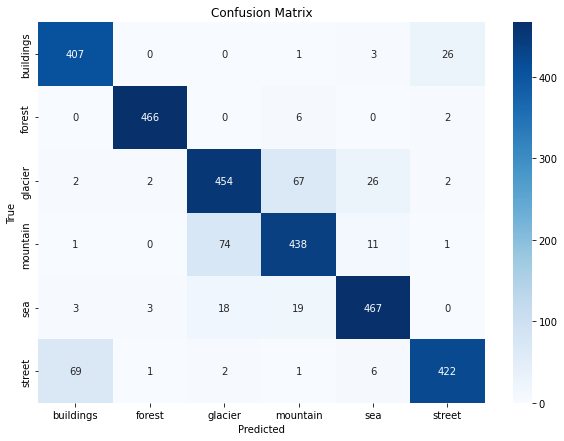

In [19]:

evaluate_model(model_conv, test_dataset, test_loader)

Отже, модель із замороженими вагами показала трохи гірший результат, хоча навчилася швидше за часом. Помилки схожі із попередньою моделлю, хоча дана модель не змогла ідентифікувати більшу частку зображень моря. Натомість, попередня дала більше false positive міток моря.

# Create custom CNN

Тепер перевіримо якість власної архітектури СNN на тих же даних. Модель включає 5 конволюційних шарів із батч-нормалізацією та ReLu після кожного згорткового шару, а також 2 лінійних шари із шаром Dropout між ними.
Натренуємо модель з нуля та порівняємо результат із трансферним навчанням. 

In [8]:

class CustomModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.num_channels = 32
        
        # Convolution layers with batch normalisation, maxpool and relu x 5
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)
        self.conv4 = nn.Conv2d(self.num_channels*4, self.num_channels*8, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.num_channels*8)
        self.conv5 = nn.Conv2d(self.num_channels*8, self.num_channels*16, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(self.num_channels*16)
        
        # dense layers with Dropout
        self.fc1 = nn.Linear(7*7*self.num_channels*16, self.num_channels*16)  
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(self.num_channels*16, 6) 

    def forward(self, s):
        # Input image: batch_size x 3 x 224 x 224
        s = F.relu(self.bn1(F.max_pool2d(self.conv1(s), 2)))  # -> batch_size x num_channels x 112 x 112
        s = F.relu(self.bn2(F.max_pool2d(self.conv2(s), 2)))  # -> batch_size x num_channels*2 x 56 x 56
        s = F.relu(self.bn3(F.max_pool2d(self.conv3(s), 2)))  # -> batch_size x num_channels*4 x 28 x 28
        s = F.relu(self.bn4(F.max_pool2d(self.conv4(s), 2)))  # -> batch_size x num_channels*8 x 14 x 14
        s = F.relu(self.bn5(F.max_pool2d(self.conv5(s), 2)))  # -> batch_size x num_channels*16 x 7 x 7

        # flatten the output for each image
        s = s.view(-1, 7*7*self.num_channels*16)  # -> batch_size x (7*7*num_channels*16)

        # dense layers with Dropout
        s = F.relu(self.fc1(s))  # -> batch_size x self.num_channels*16
        s = self.dropout(s)  
        s = self.fc2(s)  # -> batch_size x 6 (for 6 classes)

        return F.log_softmax(s, dim=1)


In [9]:
# Define the model and optimizer
model = CustomModel().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model

CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_featur

In [10]:

criterion = nn.CrossEntropyLoss()
model = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.2514 Acc: 0.4999
val Loss: 0.8171 Acc: 0.6965

Epoch 2/15
----------
train Loss: 1.0150 Acc: 0.6074
val Loss: 0.7152 Acc: 0.7461

Epoch 3/15
----------
train Loss: 0.9238 Acc: 0.6490
val Loss: 0.6303 Acc: 0.7778

Epoch 4/15
----------
train Loss: 0.8698 Acc: 0.6723
val Loss: 0.5707 Acc: 0.8049

Epoch 5/15
----------
train Loss: 0.8265 Acc: 0.6878
val Loss: 0.5952 Acc: 0.7899

Epoch 6/15
----------
train Loss: 0.7877 Acc: 0.7037
val Loss: 0.5319 Acc: 0.8160

Epoch 7/15
----------
train Loss: 0.7448 Acc: 0.7197
val Loss: 0.5193 Acc: 0.8220

Epoch 8/15
----------
train Loss: 0.7373 Acc: 0.7256
val Loss: 0.4685 Acc: 0.8345

Epoch 9/15
----------
train Loss: 0.7022 Acc: 0.7331
val Loss: 0.4796 Acc: 0.8313

Epoch 10/15
----------
train Loss: 0.6930 Acc: 0.7394
val Loss: 0.4576 Acc: 0.8413

Epoch 11/15
----------
train Loss: 0.6754 Acc: 0.7498
val Loss: 0.4551 Acc: 0.8399

Epoch 12/15
----------
train Loss: 0.6549 Acc: 0.7534
val Loss: 0.4669 Acc: 0.8374

E

C:\Users\krist\AppData\Local\Temp\ipykernel_35556\2894891286.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Accuracy: 0.8700
F1 Score: 0.8697


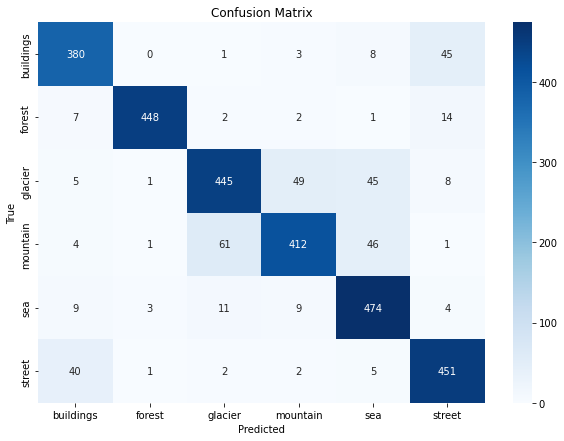

In [13]:

evaluate_model(model, test_dataset, test_loader)


Власна модель має нижчий рівень Accuracy та F1 Score, але й значно простішу архітектуру, порівняно із моделями при трансферному навчанні. Завдяки застосуванню аугментації тренувальних зображень та дропаут шару вдалося зменшити перенавчання моделі і збільшити кількість епох навчання до 15, досягнувши 86,4% ассuracy на валидаційному наборі. На тестовому наборі ассuracy досягла ще більшого рівня - 87%. Характер помилок схожий на попередні моделі: найкраще класифікуються зображення лісу, гори плутаються із льодовиками, будинки із вулицею. Є частка хибнопозитивних міток моря (сплутано з горами та льодовиками)

## Висновки

Для вирішення задачі класифікації зображень проекспериментовано як із застосуванням трансферного навчання, так і з розробкою власної архітектури СNN. До тренувальних даних застосовано різні методи аугментації. Проекспериметовано із різними розмірами батчей та кроком навчання оптимізатора. Модель ResNet50 із замороженими вагами, окрім останнього класифікаційного шару, показала гірший результат, хоча мала перевагу у швидкості навчання. Для збільшення її якості можна додатково експериментувати із кількістю шарів із замороженими вагами. Крім того, покращити результат можна було б, застосовуючи інші архітектури попередньо навчених CNN (в даній роботі використана ResNet50, що виявилася дещо кращою за метриками точності за ResNet18, але й більш обчислювально складною, що відобразилося на швидкості навчання)

Власно розроблена мщдель продемонсрувала непоганий результат, враховуючи на порядок меншу глибину порівняно з ResNet50, але оскільки потребувала навчання з нуля, мала схожу тривалість навчання за часом. Покращення результатів даної моделі вдалося досягти за допомогою налаштування кроку навчання та додавання батч-нормалізації після кожного згортвого шару із макс-пулінгом, а також додаванням шару Dropout між лінійними шарами.

